In [2]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
import time

from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np
from graph_nets.demos import models
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
import os
from Simulation_functions import SpringMassSimulator, generate_trajectory, roll_out_physics
#from Graph_creator_functions import rectangle_graph, measure_errors_deviation_from_rectangle


try:
    import seaborn as sns
except ImportError:
    pass
else:
    sns.reset_orig()

SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

/home/vabence/anaconda3/envs/TensorEnv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/vabence/anaconda3/envs/TensorEnv/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/vabence/anaconda3/envs/TensorEnv/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [3]:
def rigid_body_graph(n, spring_constant, rest_lengths, dampening):
    """Define Basic dictionary of an n-body fully connected spring system

    The mass of these objects is  1 kg.
    The rest length of all springs is rest_lengths and all springs have a spring constant of spring_constant.
    All initials velocities are 0m/s.

    Arg:
        #n - the number of objects
        #spring_constant - the spring constant in N/m
        #rest_lengths - the rest lengths in m
        #indeces_of_fixed - a list consisting of the indeces of the nodes that are fixed
        #dampening - the dampening ratio

    #Returns:
        #dict - dictionary of the graph"""
    
    # Nodes
    # Each node has an x,y position and an x_v,y_v velocity
    nodes = np.zeros((n, 5), dtype=np.float64)
    if(n==5):
        # sampl = np.random.uniform(low=-10, high=10,size=(n,2))
        nodes[0, 0:2] = [-20, -5]
        nodes[1, 0:2] = [-20, 5]
        nodes[2, 0:2] = [20, -5]
        nodes[3, 0:2] = [20, 5]

        nodes[4, 4] = 1
        
    elif(n==7):
        # sampl = np.random.uniform(low=-10, high=10,size=(n,2))
        nodes[0, 0:2] = [-10,-10]
        nodes[1, 0:2] = [-12,0]
        nodes[2, 0:2] = [-10,10]
        nodes[3, 0:2] = [10,10]
        nodes[4, 0:2] = [12,0]
        nodes[5, 0:2] = [10,-10]

        nodes[6, 4] = 1
    
    else:
        nodes[:-1,0:2] = np.random.uniform(low=-10, high=10,size=(n-1,2))
        nodes[n-1, 4] = 1
    

    # Edges
    # This is fully connected graph
    edges = np.array([spring_constant, rest_lengths, dampening] * (n - 1) * (n - 2), dtype=np.float64).reshape(
        ((n - 1) * (n - 2), 3))
    senders = []
    receivers = []
    for i in range(n - 1):
        senders.extend([i] * (n - 2))  # index of the sender
        var = list(range(n))
        var.remove(i)
        var.remove(n - 1)
        receivers.extend(var)  # index of the receiver

    senders.extend([0, n - 1])  # node 0 sends an edge, node n-1 sends an edge
    receivers.extend([n - 1, 0])  # node n-1, the fixed, receives it,  node 0 receives it
    edges = np.concatenate((edges, np.array([10., rest_lengths, dampening] * 2, dtype=np.float64).reshape(2, 3)),
                           axis=0)

    return {
        "globals": np.float64([0., -10., 0]),  # 3rd dimension of global feature is potential energy
        "nodes": np.float64(nodes),
        "edges": np.float64(edges),
        "receivers": receivers,
        "senders": senders}



def rigid_body_rectangle(len_a, len_b, spring_constant, rest_lengths, dampening):
    """Define Basic dictionary of an n-body fully connected spring system

    The mass of these objects is  1 kg.
    The rest length of all springs is rest_lengths and all springs have a spring constant of spring_constant.
    All initials velocities are 0m/s.

    Arg:
        #len_a - half of the distance between 2 node for an edge on the x axis 
        #len_b - half of the distance between 2 node for an edge on the y axis
        #spring_constant - the spring constant in N/m
        #rest_lengths - the rest lengths in m
        #indeces_of_fixed - a list consisting of the indeces of the nodes that are fixed
        #dampening - the dampening ratio

    #Returns:
        #dict - dictionary of the graph"""
    n = 5
    # Nodes
    # Each node has an x,y position and an x_v,y_v velocity
    nodes = np.zeros((n, 5), dtype=np.float64)
    nodes[0, 0:2] = [-len_a, -len_b]
    nodes[1, 0:2] = [-len_a, len_b]
    nodes[2, 0:2] = [len_a, -len_b]
    nodes[3, 0:2] = [len_a, len_b]
    nodes[4, 4] = 1


    # Edges
    # This is fully connected graph
    edges = np.array([spring_constant, rest_lengths, dampening] * (n - 1) * (n - 2), dtype=np.float64).reshape(
        ((n - 1) * (n - 2), 3))
    senders = []
    receivers = []
    for i in range(n - 1):
        senders.extend([i] * (n - 2))  # index of the sender
        var = list(range(n))
        var.remove(i)
        var.remove(n - 1)
        receivers.extend(var)  # index of the receiver

    senders.extend([0, n - 1])  # node 0 sends an edge, node n-1 sends an edge
    receivers.extend([n - 1, 0])  # node n-1, the fixed, receives it,  node 0 receives it
    edges = np.concatenate((edges, np.array([10., rest_lengths, dampening] * 2, dtype=np.float64).reshape(2, 3)),
                           axis=0)

    return {
        "globals": np.float64([0., -10., 0]),  # 3rd dimension of global feature is potential energy
        "nodes": np.float64(nodes),
        "edges": np.float64(edges),
        "receivers": receivers,
        "senders": senders}

def rigid_body_rectangle_moving_contact(len_a, len_b, spring_constant, rest_lengths, dampening,vel_x,vel_y):
    """Define Basic dictionary of an n-body fully connected spring system

    The mass of these objects is  1 kg.
    The rest length of all springs is rest_lengths and all springs have a spring constant of spring_constant.
    All initials velocities are 0m/s.

    Arg:
        #len_a - half of the distance between 2 node for an edge on the x axis 
        #len_b - half of the distance between 2 node for an edge on the y axis
        #spring_constant - the spring constant in N/m
        #rest_lengths - the rest lengths in m
        #indeces_of_fixed - a list consisting of the indeces of the nodes that are fixed
        #dampening - the dampening ratio

    #Returns:
        #dict - dictionary of the graph"""
    n = 5
    # Nodes
    # Each node has an x,y position and an x_v,y_v velocity
    nodes = np.zeros((n, 5), dtype=np.float64)
    nodes[0, 0:2] = [-len_a, -len_b]
    nodes[1, 0:2] = [-len_a, len_b]
    nodes[2, 0:2] = [len_a, -len_b]
    nodes[3, 0:2] = [len_a, len_b]
    
    nodes[4, 4] = 1
    nodes[4, 2:4] = [vel_x,vel_y]

    # Edges
    # This is fully connected graph
    edges = np.array([spring_constant, rest_lengths, dampening] * (n - 1) * (n - 2), dtype=np.float64).reshape(
        ((n - 1) * (n - 2), 3))
    senders = []
    receivers = []
    for i in range(n - 1):
        senders.extend([i] * (n - 2))  # index of the sender
        var = list(range(n))
        var.remove(i)
        var.remove(n - 1)
        receivers.extend(var)  # index of the receiver

    senders.extend([0, n - 1])  # node 0 sends an edge, node n-1 sends an edge
    receivers.extend([n - 1, 0])  # node n-1, the fixed, receives it,  node 0 receives it
    edges = np.concatenate((edges, np.array([10., rest_lengths, dampening] * 2, dtype=np.float64).reshape(2, 3)),
                           axis=0)

    return {
        "globals": np.float64([0., -10., 0]),  # 3rd dimension of global feature is energy
        "nodes": np.float64(nodes),
        "edges": np.float64(edges),
        "receivers": receivers,
        "senders": senders}





## Declare loss opration

In [4]:

def create_loss_ops_with_energy(target_op, output_ops,target_global_energy):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op."""

    
    loss_ops = [
            tf.reduce_mean(
            tf.reduce_sum(
                (tf.cast(output_op.globals[...,2:3],tf.float64) - tf.cast(target_global_energy[..., 2:3],tf.float64))**2, axis=-1))
            + tf.reduce_mean(
            tf.reduce_sum(
                (tf.cast(output_op.nodes,tf.float64) - tf.cast(target_op[..., 2:4],tf.float64))**2, axis=-1))
             for output_op in output_ops
    ]
    return loss_ops


def create_loss_ops(target_op, output_ops):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op.""" 
    loss_ops = [
            tf.reduce_mean(
            tf.reduce_sum((tf.cast(output_op.nodes,tf.float64) - tf.cast(target_op[..., 2:4],tf.float64))**2, axis=-1))
            for output_op in output_ops
    ]
    return loss_ops





def make_all_runnable_in_session(*args):
    """Apply make_runnable_in_session to an iterable of graphs."""
    return [utils_tf.make_runnable_in_session(a) for a in args]


# pylint: enable=redefined-outer-name

# Training the Network: Chain with Energy
## Generate:
- Model
- Training trajectory
- Generalization trajectories: 4 mass, 9 mass

In [5]:

tf.reset_default_graph()

rand = np.random.RandomState(SEED)

# Model parameters.
num_processing_steps_tr = 1
num_processing_steps_ge = 1

# Data / training parameters.~
num_training_iterations = 150000
batch_size_tr = 256
batch_size_ge = 100
num_time_steps = 50
step_size = 0.1

len_a_mix_max = (10,40)
len_b_mix_max = (10,40)

vel_x_min_max = (0.,5.)
vel_y_min_max = (-2.,2.)


# Create the model.
model = models.EncodeProcessDecode(node_output_size=2,edge_output_size=2,global_output_size=3)

len_as = rand.randint(*len_a_mix_max, size=batch_size_tr)
len_bs = rand.randint(*len_b_mix_max, size=batch_size_tr)

vel_xs = rand.randint(*vel_x_min_max, size=batch_size_tr)
vel_ys = rand.randint(*vel_y_min_max, size=batch_size_tr)


static_graph_tr = [rigid_body_rectangle_moving_contact(15,15, 50., 1, 0.,vel_x,vel_y) for vel_x,vel_y in zip(vel_xs,vel_ys)]
base_graph_tr =  utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)
#base_graph_tr =  utils_tf.data_dicts_to_graphs_tuple([rigid_body_rectangle_moving_contact(30, 30,50,1,0.,0.5,0)] * batch_size_tr)

base_graph_4_ge = utils_tf.data_dicts_to_graphs_tuple([rigid_body_rectangle_moving_contact(15, 15,50,1,0.,5,-2)] * batch_size_ge)

simulator = SpringMassSimulator(step_size=step_size)
# Training.
# Generate a training trajectory by adding noise to initial
# position, spring constants and gravity
initial_conditions_tr, true_trajectory_tr, true_globals_tr_per_step = generate_trajectory(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0,
    do_set_rest=True,do_apply_gravity=False)

t = tf.random_uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
target_nodes_tr = true_trajectory_tr[t + 1]
output_ops_tr = model(input_graph_tr, num_processing_steps_tr)


# Test data: 4-mass string.
initial_conditions_4_ge, _, _ = generate_trajectory(
    lambda x: model(x, num_processing_steps_ge),
    base_graph_4_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0,
    do_set_rest=True,do_apply_gravity=False)

_, true_nodes_rollout_4_ge, true_globals_4_per_step = roll_out_physics(
    simulator, initial_conditions_4_ge, num_time_steps, step_size)
_, predicted_nodes_rollout_4_ge, predicted_globals_4_per_step = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), initial_conditions_4_ge,num_time_steps, step_size)


# Training loss.
#loss_ops_tr = create_loss_ops_with_energy(target_nodes_tr, output_ops_tr,true_globals_tr_per_step)
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss: 4-mass.
loss_op_4_ge = tf.reduce_mean(
                tf.reduce_sum(
                    (predicted_nodes_rollout_4_ge[..., 2:4]-true_nodes_rollout_4_ge[..., 2:4])**2,axis=-1))
"""
loss_op_4_ge +=tf.reduce_mean(
                tf.reduce_sum(
                    (predicted_globals_4_per_step[...,2:3]-true_globals_4_per_step[...,2:3])**2,axis=-1))
""" 



# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

input_graph_tr = make_all_runnable_in_session(input_graph_tr)
initial_conditions_4_ge = make_all_runnable_in_session(initial_conditions_4_ge)


In [6]:
#@title Reset session  { form-width: "30%" }

# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
losses_4_ge = []

## Training the Network

In [7]:
# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), "
      "Lge4 (test/generalization rollout loss for 4-mass strings)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "input_graph": input_graph_tr,
        "target_nodes": target_nodes_tr,
        "target_globals":true_globals_tr_per_step,
        "outputs": output_ops_tr})
    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    if elapsed_since_last_log > log_every_seconds:
        last_log_time = the_time
        test_values = sess.run({
            "loss_4": loss_op_4_ge,
            "true_rollout_4": true_nodes_rollout_4_ge,
            "true_globals_4": true_globals_4_per_step,
            "predicted_rollout_4": predicted_nodes_rollout_4_ge,
            "predicted_globals_4": predicted_globals_4_per_step})
        elapsed = time.time() - start_time
        losses_tr.append(train_values["loss"])
        losses_4_ge.append(test_values["loss_4"])
        logged_iterations.append(iteration)
        print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge4 {:.4f}".format(
            iteration, elapsed, train_values["loss"], test_values["loss_4"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), Lge4 (test/generalization rollout loss for 4-mass strings)
# 00029, T 21.0, Ltr 1.4366, Lge4 12.9341
# 00060, T 41.0, Ltr 1.7960, Lge4 11.2831
# 00092, T 61.4, Ltr 0.8685, Lge4 10.2753
# 00124, T 81.6, Ltr 1.5396, Lge4 8.9486
# 00156, T 102.0, Ltr 0.4290, Lge4 8.5739
# 00189, T 122.3, Ltr 0.5093, Lge4 8.0722
# 00222, T 142.3, Ltr 0.5888, Lge4 7.8063
# 00256, T 162.9, Ltr 0.5497, Lge4 7.6696
# 00290, T 183.5, Ltr 0.3483, Lge4 7.4325
# 00324, T 204.0, Ltr 0.3950, Lge4 7.3375
# 00357, T 224.1, Ltr 0.3266, Lge4 7.7927
# 00391, T 244.6, Ltr 0.2844, Lge4 7.7802
# 00424, T 264.7, Ltr 0.2287, Lge4 7.9650
# 00457, T 285.1, Ltr 0.3049, Lge4 8.0501
# 00490, T 305.2, Ltr 0.1493, Lge4 8.2585
# 00524, T 325.8, Ltr 0.2073, Lge4 8.3209
# 00557, T 345.8, Ltr 0.2064, Lge4 8.4460
# 00590, T 365.8, Ltr 0.1542, Lge4 8.6447
# 00623, T 385.9, Ltr 0.1775, Lge4 8.5758
# 00656, T 405.9, Ltr 0.1797, Lge4 8.5292
# 00690, T 426.5, Ltr 0.0978, L

# 06204, T 3774.3, Ltr 0.0480, Lge4 13.0509
# 06237, T 3794.6, Ltr 0.0244, Lge4 14.9900
# 06270, T 3814.7, Ltr 0.0194, Lge4 13.4609
# 06303, T 3834.8, Ltr 0.0176, Lge4 13.2113
# 06336, T 3854.8, Ltr 0.0253, Lge4 12.2941
# 06369, T 3874.9, Ltr 0.0132, Lge4 12.0128
# 06402, T 3894.9, Ltr 0.0355, Lge4 14.3861
# 06435, T 3915.0, Ltr 0.0094, Lge4 15.2639
# 06468, T 3935.1, Ltr 0.0339, Lge4 13.0003
# 06501, T 3955.1, Ltr 0.0402, Lge4 11.4063
# 06534, T 3975.2, Ltr 0.0322, Lge4 15.9624
# 06567, T 3995.2, Ltr 0.0398, Lge4 13.6612
# 06600, T 4015.2, Ltr 0.0413, Lge4 11.5763
# 06633, T 4035.3, Ltr 0.0422, Lge4 6.0621
# 06666, T 4055.4, Ltr 0.0339, Lge4 12.5082
# 06699, T 4075.4, Ltr 0.0299, Lge4 6.0593
# 06732, T 4095.5, Ltr 0.0103, Lge4 6.2001
# 06765, T 4115.5, Ltr 0.0316, Lge4 12.2710
# 06798, T 4135.6, Ltr 0.0120, Lge4 7.6916
# 06831, T 4155.6, Ltr 0.0131, Lge4 6.0349
# 06864, T 4175.7, Ltr 0.0245, Lge4 10.6594
# 06897, T 4195.8, Ltr 0.0147, Lge4 11.9257
# 06930, T 4215.8, Ltr 0.0468, Lge4 1

# 12441, T 7571.6, Ltr 0.0225, Lge4 9.2342
# 12474, T 7591.8, Ltr 0.0137, Lge4 6.3126
# 12507, T 7611.9, Ltr 0.0228, Lge4 8.4134
# 12540, T 7632.0, Ltr 0.0056, Lge4 7.3245
# 12573, T 7652.1, Ltr 0.0184, Lge4 9.4824
# 12606, T 7672.2, Ltr 0.0324, Lge4 5.0924
# 12639, T 7692.3, Ltr 0.0345, Lge4 5.2259
# 12672, T 7712.5, Ltr 0.0301, Lge4 15.0587
# 12705, T 7732.6, Ltr 0.0194, Lge4 5.2363
# 12738, T 7752.7, Ltr 0.0177, Lge4 9.4835
# 12771, T 7773.1, Ltr 0.0209, Lge4 10.0163
# 12804, T 7793.6, Ltr 0.0088, Lge4 8.6008
# 12837, T 7813.7, Ltr 0.0340, Lge4 5.9210
# 12870, T 7833.9, Ltr 0.0128, Lge4 8.0355
# 12903, T 7854.0, Ltr 0.0311, Lge4 5.6563
# 12936, T 7874.0, Ltr 0.0162, Lge4 11.2259
# 12969, T 7894.2, Ltr 0.0339, Lge4 9.2023
# 13002, T 7914.4, Ltr 0.0310, Lge4 9.0397
# 13035, T 7934.4, Ltr 0.0362, Lge4 5.8881
# 13068, T 7954.5, Ltr 0.0342, Lge4 6.4682
# 13101, T 7974.7, Ltr 0.0079, Lge4 5.6455
# 13134, T 7994.7, Ltr 0.0153, Lge4 8.0916
# 13167, T 8014.9, Ltr 0.0367, Lge4 5.2008
# 13200,

# 18678, T 11380.4, Ltr 0.0160, Lge4 5.4766
# 18711, T 11400.6, Ltr 0.0074, Lge4 3.9689
# 18744, T 11420.8, Ltr 0.0343, Lge4 4.1342
# 18777, T 11441.0, Ltr 0.0269, Lge4 6.1439
# 18810, T 11461.2, Ltr 0.0161, Lge4 8.1982
# 18843, T 11481.3, Ltr 0.0204, Lge4 4.0350
# 18876, T 11501.5, Ltr 0.0087, Lge4 5.8365
# 18909, T 11521.7, Ltr 0.0139, Lge4 5.5140
# 18942, T 11541.9, Ltr 0.0118, Lge4 3.4820
# 18975, T 11562.0, Ltr 0.0310, Lge4 24.7264
# 19008, T 11582.2, Ltr 0.0112, Lge4 5.2374
# 19041, T 11602.3, Ltr 0.0174, Lge4 6.0005
# 19074, T 11622.5, Ltr 0.0188, Lge4 6.8895
# 19107, T 11642.7, Ltr 0.0173, Lge4 18.0174
# 19140, T 11662.9, Ltr 0.0156, Lge4 8.8156
# 19173, T 11683.0, Ltr 0.0131, Lge4 5.9411
# 19206, T 11703.2, Ltr 0.0111, Lge4 5.1352
# 19239, T 11723.4, Ltr 0.0119, Lge4 4.5354
# 19272, T 11743.5, Ltr 0.0072, Lge4 7.9243
# 19305, T 11763.7, Ltr 0.0314, Lge4 4.0117
# 19338, T 11783.9, Ltr 0.0069, Lge4 12.1546
# 19371, T 11804.0, Ltr 0.0123, Lge4 6.7305
# 19404, T 11824.2, Ltr 0.033

# 24816, T 15137.2, Ltr 0.0396, Lge4 4.3357
# 24849, T 15157.4, Ltr 0.0054, Lge4 4.8938
# 24882, T 15177.6, Ltr 0.0425, Lge4 4.1464
# 24915, T 15197.8, Ltr 0.0190, Lge4 1.9390
# 24948, T 15218.0, Ltr 0.0291, Lge4 3.5025
# 24981, T 15238.3, Ltr 0.0102, Lge4 7.4850
# 25014, T 15258.5, Ltr 0.0248, Lge4 5.2115
# 25047, T 15278.7, Ltr 0.0242, Lge4 3.9342
# 25080, T 15299.0, Ltr 0.0042, Lge4 3.4286
# 25113, T 15319.1, Ltr 0.0305, Lge4 3.3567
# 25146, T 15339.4, Ltr 0.0106, Lge4 3.8652
# 25179, T 15359.7, Ltr 0.0156, Lge4 5.2690
# 25212, T 15379.8, Ltr 0.0100, Lge4 8.3966
# 25245, T 15400.1, Ltr 0.0287, Lge4 4.6317
# 25278, T 15420.2, Ltr 0.0093, Lge4 3.3186
# 25311, T 15440.5, Ltr 0.0174, Lge4 5.3761
# 25344, T 15460.7, Ltr 0.0071, Lge4 9.5637
# 25377, T 15480.9, Ltr 0.0074, Lge4 5.6200
# 25410, T 15501.1, Ltr 0.0228, Lge4 3.4462
# 25443, T 15521.3, Ltr 0.0089, Lge4 11.5464
# 25476, T 15541.5, Ltr 0.0195, Lge4 8.9196
# 25509, T 15561.8, Ltr 0.0148, Lge4 3.8326
# 25542, T 15582.0, Ltr 0.0216,

# 30954, T 18903.1, Ltr 0.0126, Lge4 2.9204
# 30987, T 18923.3, Ltr 0.0108, Lge4 6.4642
# 31020, T 18943.7, Ltr 0.0058, Lge4 4.5900
# 31053, T 18963.9, Ltr 0.0147, Lge4 21.9331
# 31086, T 18984.2, Ltr 0.0064, Lge4 4.9004
# 31119, T 19004.5, Ltr 0.0117, Lge4 4.7368
# 31152, T 19024.7, Ltr 0.0174, Lge4 5.2041
# 31185, T 19044.9, Ltr 0.0195, Lge4 3.5221
# 31218, T 19065.3, Ltr 0.0171, Lge4 2.2947
# 31251, T 19085.5, Ltr 0.0149, Lge4 3.7966
# 31284, T 19105.8, Ltr 0.0101, Lge4 3.0813
# 31317, T 19126.1, Ltr 0.0037, Lge4 4.4613
# 31350, T 19146.4, Ltr 0.0061, Lge4 5.7910
# 31383, T 19166.7, Ltr 0.0201, Lge4 3.5269
# 31416, T 19187.0, Ltr 0.0073, Lge4 4.6104
# 31449, T 19207.3, Ltr 0.0119, Lge4 6.4407
# 31482, T 19227.6, Ltr 0.0231, Lge4 4.2460
# 31515, T 19247.8, Ltr 0.0252, Lge4 3.3216
# 31548, T 19268.1, Ltr 0.0051, Lge4 2.6584
# 31581, T 19288.3, Ltr 0.0202, Lge4 4.3553
# 31614, T 19308.6, Ltr 0.0312, Lge4 5.4371
# 31647, T 19328.9, Ltr 0.0176, Lge4 6.3891
# 31680, T 19349.2, Ltr 0.0206,

# 37092, T 22678.5, Ltr 0.0090, Lge4 2.3483
# 37125, T 22698.9, Ltr 0.0067, Lge4 4.3640
# 37158, T 22719.2, Ltr 0.0098, Lge4 6.2692
# 37191, T 22739.6, Ltr 0.0068, Lge4 2.6227
# 37224, T 22759.8, Ltr 0.0164, Lge4 4.1786
# 37257, T 22780.2, Ltr 0.0144, Lge4 4.6696
# 37290, T 22800.5, Ltr 0.0103, Lge4 5.8885
# 37323, T 22820.8, Ltr 0.0084, Lge4 3.6226
# 37356, T 22841.1, Ltr 0.0152, Lge4 3.0612
# 37389, T 22861.3, Ltr 0.0189, Lge4 2.3430
# 37422, T 22881.7, Ltr 0.0175, Lge4 5.1352
# 37455, T 22902.0, Ltr 0.0227, Lge4 5.7271
# 37488, T 22922.4, Ltr 0.0177, Lge4 3.1486
# 37521, T 22942.6, Ltr 0.0082, Lge4 5.6613
# 37554, T 22962.9, Ltr 0.0158, Lge4 4.6638
# 37587, T 22983.2, Ltr 0.0055, Lge4 9.8703
# 37620, T 23003.5, Ltr 0.0092, Lge4 2.3436
# 37653, T 23023.9, Ltr 0.0096, Lge4 3.9132
# 37686, T 23044.1, Ltr 0.0188, Lge4 4.2316
# 37719, T 23064.5, Ltr 0.0232, Lge4 1.7565
# 37752, T 23084.8, Ltr 0.0187, Lge4 2.0243
# 37785, T 23105.3, Ltr 0.0185, Lge4 4.2395
# 37818, T 23125.6, Ltr 0.0161, 

# 43230, T 26461.8, Ltr 0.0218, Lge4 2.4416
# 43263, T 26482.2, Ltr 0.0019, Lge4 4.4695
# 43296, T 26502.6, Ltr 0.0064, Lge4 4.0829
# 43329, T 26523.0, Ltr 0.0045, Lge4 3.6906
# 43362, T 26543.4, Ltr 0.0098, Lge4 1.5497
# 43395, T 26563.7, Ltr 0.0156, Lge4 5.0646
# 43428, T 26584.2, Ltr 0.0143, Lge4 2.6985
# 43461, T 26604.5, Ltr 0.0219, Lge4 3.7588
# 43494, T 26624.8, Ltr 0.0071, Lge4 4.5178
# 43527, T 26645.3, Ltr 0.0126, Lge4 23.8796
# 43560, T 26665.6, Ltr 0.0056, Lge4 3.8964
# 43593, T 26686.0, Ltr 0.0156, Lge4 4.6502
# 43626, T 26706.3, Ltr 0.0173, Lge4 4.6569
# 43659, T 26726.6, Ltr 0.0256, Lge4 2.0904
# 43691, T 26746.7, Ltr 0.0086, Lge4 2.4713
# 43724, T 26767.0, Ltr 0.0085, Lge4 3.1204
# 43757, T 26787.3, Ltr 0.0128, Lge4 4.6310
# 43790, T 26807.7, Ltr 0.0074, Lge4 5.7093
# 43823, T 26828.0, Ltr 0.0091, Lge4 19.8266
# 43856, T 26848.5, Ltr 0.0116, Lge4 5.0261
# 43889, T 26868.8, Ltr 0.0097, Lge4 4.4580
# 43922, T 26889.1, Ltr 0.0090, Lge4 5.3581
# 43955, T 26909.6, Ltr 0.0109

# 49400, T 30272.6, Ltr 0.0163, Lge4 4.5775
# 49433, T 30293.0, Ltr 0.0065, Lge4 5.0790
# 49466, T 30313.4, Ltr 0.0099, Lge4 4.9753
# 49499, T 30333.8, Ltr 0.0166, Lge4 6.2222
# 49532, T 30354.2, Ltr 0.0068, Lge4 1.7162
# 49565, T 30374.9, Ltr 0.0072, Lge4 4.2947
# 49598, T 30395.3, Ltr 0.0036, Lge4 3.4616
# 49631, T 30415.6, Ltr 0.0026, Lge4 1.5646
# 49664, T 30436.1, Ltr 0.0046, Lge4 3.3372
# 49697, T 30456.5, Ltr 0.0137, Lge4 4.3573
# 49730, T 30476.8, Ltr 0.0056, Lge4 1.3175
# 49763, T 30497.3, Ltr 0.0154, Lge4 1.5096
# 49796, T 30517.6, Ltr 0.0187, Lge4 3.6000
# 49829, T 30538.0, Ltr 0.0232, Lge4 7.4636
# 49862, T 30558.5, Ltr 0.0044, Lge4 2.9840
# 49895, T 30578.9, Ltr 0.0157, Lge4 1.8736
# 49928, T 30599.2, Ltr 0.0027, Lge4 1.2175
# 49961, T 30619.7, Ltr 0.0167, Lge4 4.7910
# 49994, T 30640.1, Ltr 0.0096, Lge4 4.5869
# 50027, T 30660.6, Ltr 0.0204, Lge4 4.2189
# 50060, T 30681.0, Ltr 0.0137, Lge4 8.5051
# 50093, T 30701.4, Ltr 0.0222, Lge4 2.6372
# 50126, T 30721.9, Ltr 0.0111, 

# 55571, T 34091.7, Ltr 0.0070, Lge4 3.0935
# 55604, T 34112.1, Ltr 0.0152, Lge4 3.5769
# 55637, T 34132.5, Ltr 0.0059, Lge4 2.8866
# 55670, T 34152.9, Ltr 0.0075, Lge4 2.9916
# 55703, T 34173.4, Ltr 0.0069, Lge4 2.9392
# 55736, T 34193.8, Ltr 0.0142, Lge4 4.7203
# 55769, T 34214.2, Ltr 0.0097, Lge4 5.7380
# 55802, T 34234.6, Ltr 0.0113, Lge4 6.5981
# 55835, T 34255.1, Ltr 0.0067, Lge4 3.4746
# 55868, T 34275.6, Ltr 0.0167, Lge4 5.2761
# 55901, T 34296.0, Ltr 0.0070, Lge4 6.7867
# 55934, T 34316.4, Ltr 0.0021, Lge4 3.6924
# 55967, T 34336.8, Ltr 0.0128, Lge4 3.9827
# 56000, T 34357.3, Ltr 0.0025, Lge4 2.8780
# 56033, T 34377.7, Ltr 0.0142, Lge4 2.8543
# 56066, T 34398.0, Ltr 0.0188, Lge4 5.5859
# 56099, T 34418.5, Ltr 0.0109, Lge4 6.1218
# 56132, T 34439.0, Ltr 0.0229, Lge4 21.6421
# 56165, T 34459.4, Ltr 0.0059, Lge4 5.1665
# 56198, T 34479.8, Ltr 0.0089, Lge4 4.5287
# 56231, T 34500.2, Ltr 0.0142, Lge4 9.5770
# 56264, T 34520.8, Ltr 0.0274, Lge4 7.3965
# 56297, T 34541.3, Ltr 0.0171,

# 61739, T 37915.6, Ltr 0.0115, Lge4 5.0463
# 61772, T 37936.0, Ltr 0.0087, Lge4 3.3259
# 61805, T 37956.5, Ltr 0.0078, Lge4 4.4053
# 61838, T 37977.0, Ltr 0.0117, Lge4 3.9740
# 61871, T 37997.5, Ltr 0.0141, Lge4 11.0324
# 61904, T 38018.0, Ltr 0.0099, Lge4 4.7959
# 61937, T 38038.4, Ltr 0.0056, Lge4 3.5498
# 61970, T 38058.8, Ltr 0.0079, Lge4 3.9633
# 62003, T 38079.3, Ltr 0.0046, Lge4 3.8063
# 62036, T 38099.8, Ltr 0.0218, Lge4 3.3314
# 62069, T 38120.2, Ltr 0.0071, Lge4 5.7434
# 62102, T 38140.7, Ltr 0.0198, Lge4 3.4360
# 62135, T 38161.1, Ltr 0.0076, Lge4 3.5779
# 62168, T 38181.6, Ltr 0.0051, Lge4 2.8746
# 62201, T 38202.1, Ltr 0.0214, Lge4 3.4918
# 62234, T 38222.5, Ltr 0.0035, Lge4 4.9371
# 62267, T 38243.0, Ltr 0.0238, Lge4 18.4315
# 62300, T 38263.4, Ltr 0.0206, Lge4 1.8877
# 62333, T 38283.9, Ltr 0.0139, Lge4 2.7717
# 62366, T 38304.5, Ltr 0.0183, Lge4 5.4129
# 62399, T 38324.9, Ltr 0.0177, Lge4 3.8512
# 62432, T 38345.3, Ltr 0.0102, Lge4 3.2973
# 62465, T 38365.7, Ltr 0.0114

# 67875, T 41724.8, Ltr 0.0121, Lge4 1.6336
# 67908, T 41745.4, Ltr 0.0084, Lge4 3.0031
# 67941, T 41765.9, Ltr 0.0071, Lge4 2.2052
# 67974, T 41786.4, Ltr 0.0201, Lge4 1.5528
# 68007, T 41806.9, Ltr 0.0162, Lge4 2.4485
# 68040, T 41827.3, Ltr 0.0054, Lge4 5.5223
# 68073, T 41847.8, Ltr 0.0208, Lge4 2.7884
# 68106, T 41868.4, Ltr 0.0045, Lge4 3.0849
# 68139, T 41888.9, Ltr 0.0090, Lge4 3.3501
# 68172, T 41909.4, Ltr 0.0224, Lge4 2.0929
# 68205, T 41929.8, Ltr 0.0180, Lge4 2.6198
# 68238, T 41950.3, Ltr 0.0081, Lge4 4.9458
# 68271, T 41970.8, Ltr 0.0052, Lge4 6.2542
# 68304, T 41991.3, Ltr 0.0067, Lge4 3.2404
# 68337, T 42011.8, Ltr 0.0148, Lge4 4.7041
# 68370, T 42032.4, Ltr 0.0026, Lge4 3.7429
# 68403, T 42052.9, Ltr 0.0069, Lge4 2.9455
# 68436, T 42073.4, Ltr 0.0042, Lge4 4.9347
# 68469, T 42093.8, Ltr 0.0153, Lge4 4.3672
# 68502, T 42114.4, Ltr 0.0083, Lge4 3.5110
# 68535, T 42134.9, Ltr 0.0170, Lge4 2.5863
# 68568, T 42155.5, Ltr 0.0149, Lge4 9.7252
# 68601, T 42176.0, Ltr 0.0181, 

# 74005, T 45538.6, Ltr 0.0153, Lge4 3.3115
# 74038, T 45559.0, Ltr 0.0050, Lge4 2.0926
# 74071, T 45579.6, Ltr 0.0017, Lge4 5.4063
# 74104, T 45600.1, Ltr 0.0148, Lge4 2.7877
# 74137, T 45620.7, Ltr 0.0152, Lge4 2.5492
# 74170, T 45641.3, Ltr 0.0158, Lge4 4.6193
# 74203, T 45661.8, Ltr 0.0110, Lge4 4.5363
# 74236, T 45682.3, Ltr 0.0049, Lge4 3.7648
# 74269, T 45702.9, Ltr 0.0131, Lge4 3.4417
# 74302, T 45723.5, Ltr 0.0179, Lge4 4.0551
# 74334, T 45743.5, Ltr 0.0142, Lge4 3.6128
# 74366, T 45763.5, Ltr 0.0065, Lge4 4.3119
# 74399, T 45784.0, Ltr 0.0134, Lge4 8.0329
# 74432, T 45804.6, Ltr 0.0268, Lge4 1.6022
# 74465, T 45825.1, Ltr 0.0038, Lge4 3.7676
# 74498, T 45845.7, Ltr 0.0170, Lge4 3.1022
# 74531, T 45866.3, Ltr 0.0085, Lge4 3.1616
# 74564, T 45886.8, Ltr 0.0198, Lge4 2.5236
# 74597, T 45907.3, Ltr 0.0136, Lge4 3.0838
# 74629, T 45927.3, Ltr 0.0034, Lge4 1.7954
# 74662, T 45947.9, Ltr 0.0031, Lge4 3.3309
# 74695, T 45968.4, Ltr 0.0027, Lge4 3.0602
# 74728, T 45988.9, Ltr 0.0078, 

# 80160, T 49375.5, Ltr 0.0219, Lge4 3.7038
# 80193, T 49396.0, Ltr 0.0107, Lge4 3.5903
# 80226, T 49416.6, Ltr 0.0019, Lge4 8.9992
# 80259, T 49437.3, Ltr 0.0187, Lge4 3.1915
# 80291, T 49457.2, Ltr 0.0086, Lge4 4.1750
# 80324, T 49477.8, Ltr 0.0603, Lge4 2.4485
# 80357, T 49498.4, Ltr 0.0073, Lge4 2.1725
# 80390, T 49519.0, Ltr 0.0172, Lge4 4.4929
# 80423, T 49539.6, Ltr 0.0154, Lge4 2.4595
# 80456, T 49560.2, Ltr 0.0133, Lge4 6.9536
# 80489, T 49580.7, Ltr 0.0126, Lge4 5.6968
# 80522, T 49601.3, Ltr 0.0045, Lge4 2.8025
# 80555, T 49621.9, Ltr 0.0060, Lge4 1.6692
# 80588, T 49642.4, Ltr 0.0050, Lge4 2.3516
# 80621, T 49663.0, Ltr 0.0144, Lge4 1.9678
# 80654, T 49683.6, Ltr 0.0052, Lge4 1.4366
# 80686, T 49703.6, Ltr 0.0009, Lge4 1.4898
# 80719, T 49724.1, Ltr 0.0147, Lge4 5.5234
# 80752, T 49744.7, Ltr 0.0013, Lge4 1.7076
# 80785, T 49765.2, Ltr 0.0092, Lge4 2.2918
# 80817, T 49785.2, Ltr 0.0128, Lge4 2.9685
# 80850, T 49805.8, Ltr 0.0022, Lge4 1.7780
# 80883, T 49826.3, Ltr 0.0203, 

# 86284, T 53196.0, Ltr 0.0115, Lge4 2.9964
# 86317, T 53216.6, Ltr 0.0021, Lge4 3.3947
# 86350, T 53237.1, Ltr 0.0146, Lge4 4.4321
# 86382, T 53257.2, Ltr 0.0137, Lge4 5.5833
# 86415, T 53277.8, Ltr 0.0069, Lge4 2.3080
# 86448, T 53298.4, Ltr 0.0121, Lge4 4.1761
# 86481, T 53318.9, Ltr 0.0099, Lge4 5.5288
# 86513, T 53338.9, Ltr 0.0203, Lge4 3.8909
# 86546, T 53359.5, Ltr 0.0141, Lge4 5.1960
# 86578, T 53379.6, Ltr 0.0141, Lge4 2.9092
# 86611, T 53400.2, Ltr 0.0186, Lge4 3.7627
# 86644, T 53420.8, Ltr 0.0070, Lge4 5.3236
# 86676, T 53440.8, Ltr 0.0063, Lge4 3.7906
# 86709, T 53461.3, Ltr 0.0077, Lge4 5.6849
# 86742, T 53481.9, Ltr 0.0022, Lge4 2.6194
# 86775, T 53502.5, Ltr 0.0120, Lge4 3.1682
# 86807, T 53522.5, Ltr 0.0168, Lge4 2.8755
# 86840, T 53543.1, Ltr 0.0057, Lge4 2.8435
# 86872, T 53563.2, Ltr 0.0081, Lge4 2.7573
# 86905, T 53583.7, Ltr 0.0182, Lge4 7.7094
# 86938, T 53604.4, Ltr 0.0092, Lge4 2.3460
# 86970, T 53624.4, Ltr 0.0119, Lge4 6.1117
# 87003, T 53645.0, Ltr 0.0070, 

# 92390, T 57011.3, Ltr 0.0084, Lge4 2.5891
# 92423, T 57031.9, Ltr 0.0046, Lge4 3.2177
# 92456, T 57052.5, Ltr 0.0145, Lge4 2.9624
# 92489, T 57073.1, Ltr 0.0127, Lge4 3.8822
# 92522, T 57093.7, Ltr 0.0207, Lge4 3.6238
# 92554, T 57113.7, Ltr 0.0179, Lge4 3.6301
# 92586, T 57133.8, Ltr 0.0110, Lge4 4.2611
# 92618, T 57153.8, Ltr 0.0048, Lge4 2.3915
# 92650, T 57173.9, Ltr 0.0132, Lge4 2.9849
# 92682, T 57193.9, Ltr 0.0112, Lge4 2.1197
# 92714, T 57213.9, Ltr 0.0191, Lge4 3.4425
# 92746, T 57234.0, Ltr 0.0056, Lge4 2.5470
# 92779, T 57254.6, Ltr 0.0072, Lge4 4.3755
# 92812, T 57275.2, Ltr 0.0138, Lge4 3.7463
# 92845, T 57295.7, Ltr 0.0131, Lge4 3.3310
# 92877, T 57315.9, Ltr 0.0059, Lge4 2.9977
# 92909, T 57335.9, Ltr 0.0041, Lge4 2.2792
# 92941, T 57356.0, Ltr 0.0174, Lge4 3.3570
# 92973, T 57376.0, Ltr 0.0186, Lge4 2.9377
# 93005, T 57396.0, Ltr 0.0089, Lge4 3.1663
# 93037, T 57416.1, Ltr 0.0150, Lge4 3.4003
# 93070, T 57436.7, Ltr 0.0029, Lge4 1.7846
# 93103, T 57457.3, Ltr 0.0092, 

# 98449, T 60803.0, Ltr 0.0109, Lge4 10.3967
# 98482, T 60823.6, Ltr 0.0292, Lge4 3.9064
# 98514, T 60843.6, Ltr 0.0045, Lge4 1.6847
# 98546, T 60863.7, Ltr 0.0058, Lge4 1.7383
# 98578, T 60883.8, Ltr 0.0076, Lge4 4.6224
# 98610, T 60903.9, Ltr 0.0080, Lge4 3.2743
# 98642, T 60924.1, Ltr 0.0135, Lge4 1.8429
# 98675, T 60944.7, Ltr 0.0045, Lge4 2.5322
# 98708, T 60965.3, Ltr 0.0101, Lge4 1.7916
# 98740, T 60985.3, Ltr 0.0039, Lge4 6.2794
# 98772, T 61005.4, Ltr 0.0167, Lge4 5.7516
# 98804, T 61025.5, Ltr 0.0076, Lge4 10.6101
# 98836, T 61045.6, Ltr 0.0142, Lge4 1.9533
# 98869, T 61066.3, Ltr 0.0163, Lge4 3.8639
# 98902, T 61086.9, Ltr 0.0054, Lge4 3.7800
# 98935, T 61107.4, Ltr 0.0121, Lge4 17.9734
# 98967, T 61127.4, Ltr 0.0093, Lge4 6.3513
# 98999, T 61147.5, Ltr 0.0070, Lge4 4.4898
# 99031, T 61167.6, Ltr 0.0036, Lge4 6.6761
# 99063, T 61187.7, Ltr 0.0186, Lge4 5.0483
# 99096, T 61208.4, Ltr 0.0047, Lge4 1.5196
# 99129, T 61229.0, Ltr 0.0035, Lge4 2.3427
# 99162, T 61249.6, Ltr 0.013

# 104360, T 64507.4, Ltr 0.0116, Lge4 4.4354
# 104392, T 64527.5, Ltr 0.0030, Lge4 2.4537
# 104425, T 64548.1, Ltr 0.0019, Lge4 4.8291
# 104457, T 64568.3, Ltr 0.0056, Lge4 2.9706
# 104489, T 64588.4, Ltr 0.0187, Lge4 2.3380
# 104521, T 64608.5, Ltr 0.0047, Lge4 3.3181
# 104553, T 64628.6, Ltr 0.0112, Lge4 5.6629
# 104586, T 64649.2, Ltr 0.0060, Lge4 1.5869
# 104618, T 64669.2, Ltr 0.0027, Lge4 1.7591
# 104650, T 64689.3, Ltr 0.0038, Lge4 3.7884
# 104682, T 64709.4, Ltr 0.0083, Lge4 1.7623
# 104714, T 64729.6, Ltr 0.0093, Lge4 2.3392
# 104747, T 64750.2, Ltr 0.0070, Lge4 2.4507
# 104780, T 64770.8, Ltr 0.0084, Lge4 1.3499
# 104812, T 64790.9, Ltr 0.0165, Lge4 1.7620
# 104844, T 64810.9, Ltr 0.0134, Lge4 2.1408
# 104876, T 64831.1, Ltr 0.0094, Lge4 1.9363
# 104908, T 64851.1, Ltr 0.0074, Lge4 6.0550
# 104941, T 64871.7, Ltr 0.0094, Lge4 2.8108
# 104973, T 64891.8, Ltr 0.0128, Lge4 1.9546
# 105005, T 64912.0, Ltr 0.0153, Lge4 1.5824
# 105037, T 64932.1, Ltr 0.0200, Lge4 1.5327
# 105069, 

# 110227, T 68188.6, Ltr 0.0055, Lge4 4.2733
# 110259, T 68208.9, Ltr 0.0082, Lge4 1.6986
# 110291, T 68228.9, Ltr 0.0034, Lge4 2.0923
# 110323, T 68249.0, Ltr 0.0103, Lge4 1.7376
# 110355, T 68269.2, Ltr 0.0134, Lge4 1.1151
# 110387, T 68289.3, Ltr 0.0168, Lge4 2.5768
# 110420, T 68310.0, Ltr 0.0064, Lge4 2.5878
# 110452, T 68330.0, Ltr 0.0047, Lge4 8.2770
# 110484, T 68350.2, Ltr 0.0025, Lge4 1.7254
# 110516, T 68370.3, Ltr 0.0019, Lge4 3.7797
# 110549, T 68391.0, Ltr 0.0141, Lge4 1.3955
# 110581, T 68410.9, Ltr 0.0105, Lge4 1.3876
# 110613, T 68431.1, Ltr 0.0075, Lge4 4.3350
# 110645, T 68451.3, Ltr 0.0133, Lge4 2.6494
# 110677, T 68471.3, Ltr 0.0060, Lge4 6.8417
# 110709, T 68491.3, Ltr 0.0094, Lge4 11.5156
# 110741, T 68511.5, Ltr 0.0040, Lge4 4.5836
# 110773, T 68531.6, Ltr 0.0094, Lge4 1.8884
# 110805, T 68551.7, Ltr 0.0086, Lge4 6.3859
# 110837, T 68571.7, Ltr 0.0013, Lge4 4.6118
# 110869, T 68591.9, Ltr 0.0141, Lge4 3.4075
# 110901, T 68612.0, Ltr 0.0152, Lge4 3.0728
# 110933,

# 116069, T 71858.8, Ltr 0.0084, Lge4 4.2765
# 116101, T 71878.8, Ltr 0.0018, Lge4 2.3728
# 116133, T 71899.0, Ltr 0.0051, Lge4 3.6137
# 116165, T 71919.1, Ltr 0.0053, Lge4 10.6903
# 116198, T 71939.8, Ltr 0.0067, Lge4 3.4234
# 116230, T 71959.9, Ltr 0.0120, Lge4 3.5006
# 116262, T 71980.1, Ltr 0.0107, Lge4 8.9535
# 116294, T 72000.3, Ltr 0.0068, Lge4 3.6998
# 116327, T 72020.9, Ltr 0.0135, Lge4 2.0280
# 116359, T 72041.0, Ltr 0.0136, Lge4 2.0702
# 116391, T 72061.2, Ltr 0.0026, Lge4 3.7679
# 116423, T 72081.2, Ltr 0.0097, Lge4 11.2275
# 116455, T 72101.3, Ltr 0.0057, Lge4 8.1187
# 116487, T 72121.5, Ltr 0.0262, Lge4 3.5523
# 116519, T 72141.7, Ltr 0.0094, Lge4 6.7635
# 116552, T 72162.3, Ltr 0.0117, Lge4 3.0983
# 116584, T 72182.4, Ltr 0.0021, Lge4 1.7432
# 116616, T 72202.5, Ltr 0.0068, Lge4 1.7450
# 116648, T 72222.8, Ltr 0.0047, Lge4 3.3783
# 116681, T 72243.4, Ltr 0.0052, Lge4 2.3321
# 116713, T 72263.5, Ltr 0.0183, Lge4 4.6561
# 116745, T 72283.7, Ltr 0.0242, Lge4 14.3069
# 11677

# 121922, T 75539.6, Ltr 0.0053, Lge4 1.6508
# 121955, T 75560.2, Ltr 0.0095, Lge4 9.4100
# 121987, T 75580.3, Ltr 0.0086, Lge4 2.1039
# 122019, T 75600.6, Ltr 0.0118, Lge4 10.0880
# 122051, T 75620.6, Ltr 0.0160, Lge4 2.7121
# 122083, T 75640.7, Ltr 0.0113, Lge4 2.1483
# 122115, T 75660.9, Ltr 0.0101, Lge4 2.8763
# 122147, T 75681.0, Ltr 0.0104, Lge4 6.1465
# 122179, T 75701.1, Ltr 0.0047, Lge4 2.2577
# 122211, T 75721.3, Ltr 0.0039, Lge4 2.3483
# 122243, T 75741.5, Ltr 0.0157, Lge4 3.1526
# 122275, T 75761.5, Ltr 0.0167, Lge4 15.4478
# 122307, T 75781.8, Ltr 0.0111, Lge4 7.0675
# 122339, T 75802.0, Ltr 0.0040, Lge4 1.3397
# 122371, T 75822.0, Ltr 0.0066, Lge4 1.8526
# 122403, T 75842.2, Ltr 0.0056, Lge4 1.4726
# 122435, T 75862.3, Ltr 0.0070, Lge4 2.5187
# 122468, T 75883.0, Ltr 0.0104, Lge4 2.1052
# 122500, T 75903.1, Ltr 0.0136, Lge4 2.6423
# 122532, T 75923.3, Ltr 0.0187, Lge4 3.1482
# 122564, T 75943.5, Ltr 0.0158, Lge4 3.8099
# 122596, T 75963.5, Ltr 0.0224, Lge4 3.2134
# 122628

# 127756, T 79216.0, Ltr 0.0123, Lge4 3.1668
# 127788, T 79236.0, Ltr 0.0110, Lge4 3.1372
# 127820, T 79256.2, Ltr 0.0045, Lge4 2.4762
# 127852, T 79276.4, Ltr 0.0089, Lge4 3.5781
# 127884, T 79296.5, Ltr 0.0056, Lge4 3.5254
# 127916, T 79316.7, Ltr 0.0112, Lge4 7.8676
# 127949, T 79337.4, Ltr 0.0118, Lge4 6.7228
# 127981, T 79357.5, Ltr 0.0061, Lge4 3.2151
# 128013, T 79377.8, Ltr 0.0192, Lge4 3.6067
# 128045, T 79397.8, Ltr 0.0134, Lge4 2.7906
# 128077, T 79418.0, Ltr 0.0187, Lge4 2.6098
# 128109, T 79438.2, Ltr 0.0055, Lge4 1.8283
# 128141, T 79458.2, Ltr 0.0063, Lge4 3.5343
# 128173, T 79478.4, Ltr 0.0121, Lge4 4.9691
# 128205, T 79498.7, Ltr 0.0224, Lge4 3.9002
# 128238, T 79519.3, Ltr 0.0071, Lge4 11.5000
# 128270, T 79539.5, Ltr 0.0059, Lge4 2.8476
# 128302, T 79559.8, Ltr 0.0118, Lge4 4.3086
# 128334, T 79579.9, Ltr 0.0081, Lge4 4.3063
# 128366, T 79600.0, Ltr 0.0034, Lge4 4.4538
# 128398, T 79620.3, Ltr 0.0128, Lge4 1.4130
# 128431, T 79641.0, Ltr 0.0139, Lge4 3.7054
# 128463,

# 133604, T 82904.7, Ltr 0.0352, Lge4 16.3421
# 133636, T 82924.9, Ltr 0.0163, Lge4 4.9579
# 133669, T 82945.5, Ltr 0.0070, Lge4 3.5687
# 133701, T 82965.8, Ltr 0.0116, Lge4 3.5767
# 133733, T 82986.1, Ltr 0.0120, Lge4 3.0331
# 133765, T 83006.5, Ltr 0.0119, Lge4 6.1134
# 133797, T 83026.8, Ltr 0.0121, Lge4 3.3046
# 133829, T 83047.0, Ltr 0.0077, Lge4 3.8895
# 133861, T 83067.1, Ltr 0.0156, Lge4 4.9023
# 133893, T 83087.4, Ltr 0.0047, Lge4 3.5092
# 133925, T 83107.5, Ltr 0.0059, Lge4 3.4558
# 133957, T 83127.6, Ltr 0.0203, Lge4 7.2421
# 133989, T 83148.0, Ltr 0.0165, Lge4 2.8816
# 134022, T 83168.6, Ltr 0.0052, Lge4 3.6473
# 134054, T 83188.8, Ltr 0.0014, Lge4 4.2646
# 134086, T 83209.0, Ltr 0.0159, Lge4 4.4458
# 134119, T 83229.6, Ltr 0.0113, Lge4 6.8753
# 134151, T 83249.8, Ltr 0.0067, Lge4 18.4484
# 134183, T 83270.1, Ltr 0.0099, Lge4 5.2527
# 134215, T 83290.1, Ltr 0.0071, Lge4 3.4903
# 134247, T 83310.4, Ltr 0.0039, Lge4 3.2446
# 134279, T 83330.5, Ltr 0.0179, Lge4 8.4458
# 134311

# 139445, T 86589.5, Ltr 0.0063, Lge4 4.0827
# 139477, T 86609.8, Ltr 0.0122, Lge4 3.4017
# 139509, T 86629.8, Ltr 0.0171, Lge4 4.4797
# 139541, T 86650.1, Ltr 0.0118, Lge4 3.4892
# 139574, T 86670.8, Ltr 0.0069, Lge4 3.2286
# 139606, T 86691.0, Ltr 0.0156, Lge4 3.1887
# 139638, T 86711.3, Ltr 0.0103, Lge4 2.8257
# 139670, T 86731.3, Ltr 0.0037, Lge4 2.7564
# 139702, T 86751.7, Ltr 0.0128, Lge4 2.6401
# 139734, T 86771.7, Ltr 0.0054, Lge4 2.7941
# 139766, T 86792.0, Ltr 0.0053, Lge4 3.5569
# 139798, T 86812.3, Ltr 0.0146, Lge4 2.1528
# 139830, T 86832.3, Ltr 0.0107, Lge4 3.7185
# 139862, T 86852.6, Ltr 0.0047, Lge4 4.0387
# 139894, T 86872.7, Ltr 0.0142, Lge4 3.0293
# 139926, T 86893.0, Ltr 0.0120, Lge4 3.6790
# 139958, T 86913.2, Ltr 0.0070, Lge4 3.0224
# 139990, T 86933.3, Ltr 0.0028, Lge4 2.9189
# 140022, T 86953.5, Ltr 0.0037, Lge4 9.5640
# 140055, T 86974.2, Ltr 0.0051, Lge4 3.0119
# 140087, T 86994.5, Ltr 0.0081, Lge4 3.6598
# 140119, T 87014.8, Ltr 0.0135, Lge4 4.2894
# 140151, 

# 145278, T 90271.4, Ltr 0.0064, Lge4 3.4474
# 145310, T 90291.5, Ltr 0.0129, Lge4 2.4389
# 145342, T 90311.8, Ltr 0.0047, Lge4 2.8708
# 145374, T 90331.9, Ltr 0.0129, Lge4 2.6407
# 145406, T 90352.2, Ltr 0.0127, Lge4 16.8912
# 145438, T 90372.4, Ltr 0.0035, Lge4 3.2823
# 145470, T 90392.5, Ltr 0.0182, Lge4 4.4899
# 145502, T 90412.8, Ltr 0.0047, Lge4 4.5753
# 145535, T 90433.4, Ltr 0.0095, Lge4 5.8029
# 145567, T 90453.8, Ltr 0.0143, Lge4 3.6458
# 145599, T 90474.0, Ltr 0.0135, Lge4 3.4782
# 145631, T 90494.2, Ltr 0.0062, Lge4 4.7792
# 145663, T 90514.5, Ltr 0.0044, Lge4 4.3198
# 145695, T 90534.5, Ltr 0.0148, Lge4 10.8015
# 145727, T 90554.9, Ltr 0.0048, Lge4 4.3936
# 145759, T 90575.0, Ltr 0.0097, Lge4 6.3014
# 145791, T 90595.3, Ltr 0.0101, Lge4 4.4023
# 145823, T 90615.6, Ltr 0.0075, Lge4 5.7723
# 145855, T 90635.7, Ltr 0.0060, Lge4 4.6296
# 145887, T 90656.0, Ltr 0.0099, Lge4 3.1970
# 145920, T 90676.6, Ltr 0.0064, Lge4 5.4798
# 145952, T 90696.9, Ltr 0.0088, Lge4 3.1382
# 145984

In [9]:
# Get the weights for the model
"""
print(model.name_scopes)
print()
for i in model.trainable_variables[0:6]:
    print()
    print(i)
"""
    
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)

for var, val in zip(tvars, tvars_vals):
    print(var.name, val.shape)  # Prints the name of the variable alongside its value.


MLPGraphIndependent/graph_independent/edge_model/mlp/linear_0/w:0 (3, 16)
MLPGraphIndependent/graph_independent/edge_model/mlp/linear_0/b:0 (16,)
MLPGraphIndependent/graph_independent/edge_model/mlp/linear_1/w:0 (16, 16)
MLPGraphIndependent/graph_independent/edge_model/mlp/linear_1/b:0 (16,)
MLPGraphIndependent/graph_independent/edge_model/layer_norm/gamma:0 (16,)
MLPGraphIndependent/graph_independent/edge_model/layer_norm/beta:0 (16,)
MLPGraphIndependent/graph_independent/node_model/mlp/linear_0/w:0 (5, 16)
MLPGraphIndependent/graph_independent/node_model/mlp/linear_0/b:0 (16,)
MLPGraphIndependent/graph_independent/node_model/mlp/linear_1/w:0 (16, 16)
MLPGraphIndependent/graph_independent/node_model/mlp/linear_1/b:0 (16,)
MLPGraphIndependent/graph_independent/node_model/layer_norm/gamma:0 (16,)
MLPGraphIndependent/graph_independent/node_model/layer_norm/beta:0 (16,)
MLPGraphIndependent/graph_independent/global_model/mlp/linear_0/w:0 (3, 16)
MLPGraphIndependent/graph_independent/global

In [14]:
#Save model
tf.saved_model.save(model,"/tmp/model")

AttributeError: module 'tensorflow._api.v1.saved_model' has no attribute 'save'

<IPython.core.display.Javascript object>


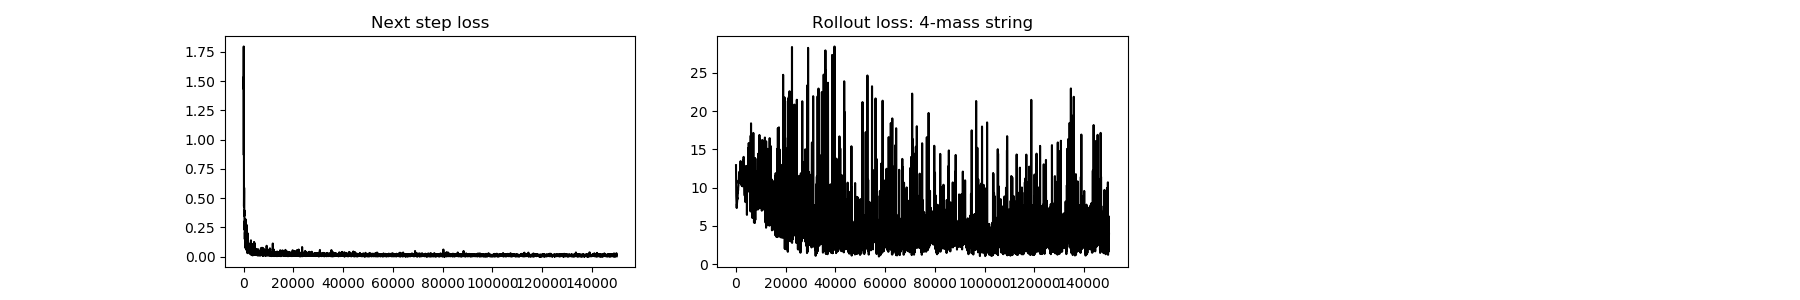

'\n# Rollout 9 loss.\ny = losses_9_ge\nax = fig.add_subplot(1, 3, 3)\nax.plot(x, y, "k")\nax.set_title("Rollout loss: 9-mass string")\nplt.show()\n'

In [10]:
BASE_PATH = "/home/vabence/git_workspace/Dyadic_Collaboration/Graph_Networks/Learning_Experiments/Results/RigidBody_two_way_fixed_box"

def get_node_trajectories(rollout_array, batch_size):  # pylint: disable=redefined-outer-name
    return np.split(rollout_array[..., :4], batch_size, axis=1)

#def get_energy_trajectories(energy_array, batch_size):
#    return np.split(energy_array[..., 2:3], batch_size, axis=1)


#Store the data
true_rollouts_4 = get_node_trajectories(test_values["true_rollout_4"],batch_size_ge)
true_trajectory_4_np = np.array(true_rollouts_4)
#true_energy_4 = get_energy_trajectories(test_values["true_globals_4"],batch_size_ge)
#true_energy_4_np = np.array(true_energy_4)

predicted_rollouts_4 = get_node_trajectories(test_values["predicted_rollout_4"],batch_size_ge)
predicted_trajectory_4_np=np.array(predicted_rollouts_4)
#predicted_energy_4 = get_energy_trajectories(test_values["predicted_globals_4"],batch_size_ge)
#predicted_energy_4_np = np.array(predicted_energy_4)
"""
true_rollouts_9 = get_node_trajectories(test_values["true_rollout_9"],batch_size_ge)
true_trajectory_9_np = np.array(true_rollouts_9)
true_energy_9 = get_energy_trajectories(test_values["true_globals_9"],batch_size_ge)
true_energy_9_np = np.array(true_energy_9)

predicted_rollouts_9 = get_node_trajectories(test_values["predicted_rollout_9"],batch_size_ge)
predicted_trajectory_9_np=np.array(predicted_rollouts_9)
predicted_energy_9 = get_energy_trajectories(test_values["predicted_globals_9"],batch_size_ge)
predicted_energy_9_np = np.array(predicted_energy_9)
"""
# Saving the data
np.save(os.path.join(BASE_PATH, "true_trajectory_4.npy"), true_trajectory_4_np)
np.save(os.path.join(BASE_PATH, "predicted_trajectory_4.npy"), predicted_trajectory_4_np)
#np.save(os.path.join(BASE_PATH, "true_energy_4.npy"), true_energy_4_np)
#np.save(os.path.join(BASE_PATH, "predicted_energy_4.npy"), predicted_energy_4_np)
"""
np.save(os.path.join(BASE_PATH, "true_trajectory_9.npy"), true_trajectory_9_np)
np.save(os.path.join(BASE_PATH, "predicted_trajectory_9.npy"), predicted_trajectory_9_np)
np.save(os.path.join(BASE_PATH, "true_energy_9.npy"), true_energy_9_np)
np.save(os.path.join(BASE_PATH, "predicted_energy_9.npy"), predicted_energy_9_np)
"""
#Getting the data
true_trajectory_4_np = np.load(os.path.join(BASE_PATH, "true_trajectory_4.npy"))[-1]
predicted_trajectory_4_np = np.load(os.path.join(BASE_PATH, "predicted_trajectory_4.npy"))[-1]
#true_energy_4_np = np.load(os.path.join(BASE_PATH, "true_energy_4.npy"))[-1]
#predicted_energy_4_np = np.load(os.path.join(BASE_PATH, "predicted_energy_4.npy"))[-1]
"""
true_trajectory_9_np = np.load(os.path.join(BASE_PATH, "true_trajectory_9.npy"))[0]
predicted_trajectory_9_np = np.load(os.path.join(BASE_PATH, "predicted_trajectory_9.npy"))[0]
true_energy_9_np = np.load(os.path.join(BASE_PATH, "true_energy_9.npy"))[0]
predicted_energy_9_np = np.load(os.path.join(BASE_PATH, "predicted_energy_9.npy"))[0]
"""

fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Next-step Loss.
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Next step loss")


# Rollout 5 loss.
y = losses_4_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 4-mass string")
"""
# Rollout 9 loss.
y = losses_9_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 9-mass string")
plt.show()
"""

<IPython.core.display.Javascript object>


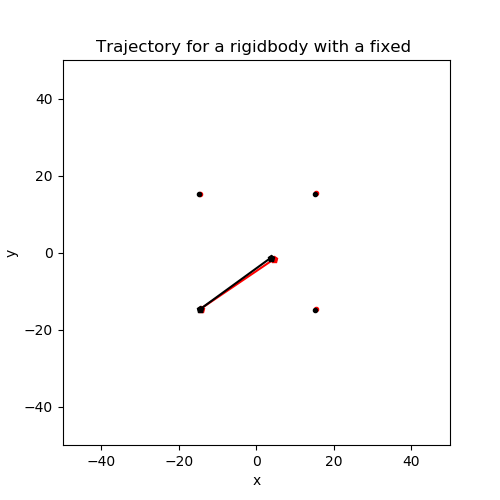

In [11]:


#
# Visualize trajectories
plt.close('all')
fig_animate1 = plt.figure(1, figsize=(5, 5))
ax1 = fig_animate1.add_subplot(1, 1, 1)
# Visualize trajectories for number_of_masses = 4


#energy_text = ax1.text(0.02, 0.90, '', transform=ax1.transAxes)
dots = []
dots1 = []
edge_between_pusher =[]
edge_between_pusher1 =[]

num_nodes = true_trajectory_4_np.shape[1]
    
def init():
    for i in range(num_nodes):
        if(i==0):
            dots.append(ax1.plot([], [], linestyle='none', marker='o', markersize=3, color="r",label="Truth"))
            dots1.append(ax1.plot([], [], linestyle='none', marker='o', markersize=3, color="k",label="Prediction"))
        else:
            dots.append(ax1.plot([], [], linestyle='none', marker='o', markersize=3, color="r"))
            dots1.append(ax1.plot([], [], linestyle='none', marker='o', markersize=3, color="k"))
        
    edge_between_pusher.append(ax1.plot([], [], linestyle='-', marker='p', markersize=5, color="r"))
    edge_between_pusher1.append(ax1.plot([], [], linestyle='-', marker='p', markersize=5, color="k"))
    
    
    return dots,dots1,edge_between_pusher,edge_between_pusher1#,legend#, energy_text
    
ax1.set_xlim(-50, 50)
ax1.set_ylim(-50, 50)


def animate(z):
    for i in range(num_nodes):
        dots[i][0].set_data(true_trajectory_4_np[z,i,0],true_trajectory_4_np[z,i,1])
        dots1[i][0].set_data(predicted_trajectory_4_np[z,i,0],predicted_trajectory_4_np[z,i,1])
    #energy_text.set_text("true_energy = %.3f J, pred_energy = %.3f J" % (true_energy_4_np[z],predicted_energy_4_np[z]))
    
    edge_between_pusher[0][0].set_data([true_trajectory_4_np[z,0,0],true_trajectory_4_np[z,num_nodes-1,0]],
                                       [true_trajectory_4_np[z,0,1],true_trajectory_4_np[z,num_nodes-1,1]])
    edge_between_pusher1[0][0].set_data([predicted_trajectory_4_np[z,0,0],predicted_trajectory_4_np[z,num_nodes-1,0]],
                                       [predicted_trajectory_4_np[z,0,1],predicted_trajectory_4_np[z,num_nodes-1,1]])

    #legend = plt.legend(loc='upper right')
    return dots,dots1,edge_between_pusher,edge_between_pusher1#,legend#,energy_text



anim = animation.FuncAnimation(fig_animate1, animate,init_func = init, interval = step_size * 1000, frames=num_time_steps, blit=False, repeat=True)
anim.save('rigidbody_moving_contact_vel_constrained_fixedbox_zerogravity.gif', writer='imagemagick', fps=20)
ax1.set_title("Trajectory for a rigidbody with a fixed ")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
plt.show()